Sneaker Resale Prices: Can We Understand the Hype?
=====================
Sameen Salam- M.S. Candidate, Institute for Advanced Analytics at North Carolina State University                                                                                                                                        
Mail: ssalam@ncsu.edu 

Introduction
------------
In this notebook, we will explore sneaker transaction data from the online marketplace StockX. StockX put out this dataset as part of its 2019 Data Challenge. The data consists of a random sample of all Off-White and Yeezy 350 sales from between 9/1/2017 (the month that Off-White first debuted “The Ten” collection) and 2/15/2019.

This is the modeling notebook. Here is an overview of how this notebook is structured:

**The Sneaker Game** - brief explanation on some basic aspects of the sneaker market  
**Feature Engineering** - conceptualization and creation of additional variables with modeling in mind  
**Modeling** - mapping out the relationships between features and the selected target  
**Conclusions** - summarzing modeling results and paths the project could take moving forward 

The Sneaker Game
---------------
Sneaker culture has become ubiquitous in recent years. All around the world, millions of sneakerheads (myself included) go online to cop the newest releases and rarest classics. But it's not always quite as simple as clicking the "Add to Cart" button and making the purchase. Some sneakers have incredibly high demand leading up to a very limited supply upon release. Only a few dedicated and/or lucky people will be successful in purchasing these shoes from a shoe store or website. Some may choose wear their shoes and keep them in their collection for years to come. But many will choose to resell deadstock (brand new) shoes at a profit in order to purchase even rarer ones.

This is where StockX, GOAT, FlightClub, or any other online sneaker marketplace comes in. Resellers need to connect with individuals who want the shoes they have up for sale. These entities offer a platform that put resellers in direct contact with potential buyers. StockX in particular prides itself on being the stock market analog in the sneaker world. Resellers can list sneakers for sale at whatever price they see fit, and buyers can make whatever bids or offers they would like on any sneaker. StockX's role in the transaction is to make sure that the resellers are selling authentic sneakers to protect buyers from receiving fake or damaged sneakers. 

Yeezys and Off-Whites are popular examples of coveted shoes that sneakerheads buy off of one another. The Yeezy line is a collaboration between Adidas and musical artist Kanye West. There are several other sneakers that fall under the Yeezy brand, but this dataset only covers Yeezy Boost 350 models. The Off-White line is a collaboration between Nike and luxury designer Virgil Abloh. Like the Yeezys, this dataset focuses in on a subset of Off-White sneaker models known as "The Ten". This is a set of ten different shoes released by Nike over a period of several months. The sneakers that carry these brand labels represent some of the most sought after kicks in the world, selling out in stores and online almost instantly upon release. 

### Value Proposition
After conducting some research on StockX's website, I found that StockX's revenue stream comes primarily from a 3% payment processing fee and a regressive transaction fee (i.e. the more a reseller sells on StockX, the lower your fee per item is). It is in StockX's best interest to foster sales of shoes with higher sale prices from a revenue standpoint. If reasonably accurate predictions can be made on resale prices as they relate to retail prices, then StockX can make decisions promoting certain sneaker listings. 

### Initial Setup
Importing needed libraries and reading in the spreadsheet directly from StockX's 2019 Data Challenge page. Note that this code will download the dataset in the form of an .xlsx spreadsheet in the directory from which this notebook is being run. 

In [3]:
#Importing the necessary libraries
import pandas as pd
from statistics import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as mpatch
import matplotlib.dates as mdate
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from regressors import stats as stats_reg
from sklearn.ensemble import RandomForestRegressor
import requests

In [8]:
#Reading in the data directly from the StockX Data Challenge 2019 webpage
url = "https://s3.amazonaws.com/stockx-sneaker-analysis/wp-content/uploads/2019/02/StockX-Data-Contest-2019-3.xlsx"
my_file = requests.get(url)
output = open('StockX-Data-Contest-2019-3.xlsx', 'wb')
output.write(my_file.content)
output.close()

#Save the contents of the excel file into variable: stockx_data
stockx_data = pd.read_excel("StockX-Data-Contest-2019-3.xlsx", sheet_name = 1)

### Preliminary Data Check
Here we are looking at some basic characteristics and quality of the dataset. Data cleaning was not a significant hurdle in this project because the dataset provided by StockX was very clean. 

In [4]:
#Taking a quick look at how the data is structured
stockx_data.head(n=5)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


Below, we confirm that the dataset has the correct dimensions: 99,956 rows and 8 columns 

In [6]:
#Getting the dimensions of the data
stockx_data.shape

(99956, 8)

From the output below, we can see that this data contains no missing values.

In [7]:
#Checking for missing values
stockx_data.isnull().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

We can see that the datatypes of the columns are congruent with the information they provide.

In [7]:
#Checking the data types of each column
stockx_data.dtypes

Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price             float64
Retail Price             int64
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

In the **Brand** variable, Yeezys were indicated by " Yeezy", making analysis more difficult. In this code, I strip all leading and trailing white space in **Brand** to make the data just a bit cleaner.

In [9]:
#Stripping all leading and trailing white space in the Brand column
stockx_data["Brand"] = stockx_data["Brand"].apply(lambda x: x.strip())

### Metadata
99,956 rows and 8 columns
    
No missing values

#### Variables
1. **Order Date**: datetime, Date the transaction occurred

2. **Brand**: string, Brand of the sneaker

3. **Sneaker Name**: string, Name of the sneaker

4. **Sale Price**: numpy float, Price paid for sneaker in transaction (resale price)

5. **Retail Price**: numpy int, Retail price of sneaker in stores (release price)

6. **Release Date**: datetime, Date the sneaker dropped

7. **Shoe Size**: numpy float, Shoe size (most likely in mens)

8. **Buyer Region**: string, transaction state (most likely for purchaser)

Feature Engineering
------------------
Sometimes the variables in your dataset do not capture the complete story. Feature engineering, or creating new variables based on ones you do have, can allow for clearer or more interesting insights and pave the way for useful models. 

With potential modeling applications in mind, here is a breakdown of some additional features I want to create: 

1. date_diff: Elapsed time between **Order Date** and **Release Date**. This allows cross comparisons of different sneakers over the same point in time after release. 

2. price_ratio: Ratio of **Sale Price** to **Retail Price**. This standardizes each shoe relative to its retail price and acts as a better indicator of the hype of any given sneaker. 

3. jordan: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is a Jordan or not. 

4. V2: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is a V2 model or not. 

5. blackcol: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe has black in the colorway or not. 

6. airmax90: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is an Airmax 90 or not. 

7. airmax97: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is an Airmax 90 or not. 

8. zoom: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe has Zoom in the name or not. 

9. presto: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is a Presto or not. 

10. airforce: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is an AirForce or not. 

11. blazer: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is a Blazer or not. 

12. vapormax: A binary indicator variable derived from **Sneaker Name** that indicates if the shoe is an Vapor Max or not. 

13. california: A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from California or not. 

14. new_york: A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from New York or not. 

15. oregon: A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from Oregon or not. 

16. florida: A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from Florida or not. 

17. texas:  A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from Texas or not. 

18. other_state: A binary indicator variable derived from **Buyer Region** that indicates if the buyer is from any other state. The states in this category had <5% of transactions in the data.  

19. brand2: A binary indicator variable derived from **Brand** for modeling. Yeezy = 1, Off-White = 0.

In [10]:
#Taking the difference between Order Date and Release Date to create a new column: date_diff
stockx_data["date_diff"] = stockx_data['Order Date'].sub(stockx_data['Release Date'], axis=0)/np.timedelta64('1','D')

#Creating a new column containing the ratio of Sale Price and Retail Price: price_ratio
stockx_data["price_ratio"] = stockx_data["Sale Price"]/stockx_data["Retail Price"]

#Creating the jordan variable
stockx_data["jordan"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Jordan' in x.split("-") else 0)

#Creating the V2 variable
stockx_data["V2"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'V2' in x.split("-") else 0)

#Creating the blackcol variable
stockx_data["blackcol"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Black' in x.split("-") else 0)

#Creating the airmax90 variable
stockx_data["airmax90"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '90' in x.split("-") else 0)

#Creating the airmax97 variable
stockx_data["airmax97"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '97' in x.split("-") else 0)

#Creating the zoom variable
stockx_data["zoom"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Zoom' in x.split("-") else 0)

#Creating the presto variable
stockx_data["presto"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Presto' in x.split("-") else 0)

#Creating the airforce variable
stockx_data["airforce"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Force' in x.split("-") else 0)

#Creating the blazer variable
stockx_data["blazer"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Blazer' in x.split("-") else 0)

#Creating the vapormax variable
stockx_data["vapormax"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'VaporMax' in x.split("-") else 0)

#Creating the california variable
stockx_data["california"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'California' in x else 0)

#Creating the new_york variable
stockx_data["new_york"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'New York' in x else 0)

#Creating the oregon variable
stockx_data["oregon"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Oregon' in x else 0)

#Creating the florida variable
stockx_data["florida"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Florida' in x else 0)

#Creating the texas variable
stockx_data["texas"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Texas' in x else 0)

#Creating the other_state variable
above5pct_states = ["California", "New York", "Oregon", "Florida", "Texas"]
stockx_data["other_state"] = pd.Series(list(map(int,~stockx_data["Buyer Region"].isin(above5pct_states))))

#Creating the brand2 variable
stockx_data["brand2"] = stockx_data["Brand"].apply(lambda x : 1 if 'Yeezy' in x else 0)

Modeling
------------
In this section, we are going to do some predictive modeling on **price_ratio**. After doing some data processing, we will attempt some multiple linear regression models to predict **price_ratio**. After evaluating these linear models for performance and validity, we will move on to random forest regression models and compare their performances. All regression models in this notebook will be compared using mean absolute percent error, or MAPE. This metric can be interpreted as follows: "On average, the model outputs predictions that are XX.X% off from the true value."

### Data Pre-Processing

Since **date_diff** is a direct linear combination of **Order Date** and **Release Date**, we will drop these variables before splitting the dataset. 

In [11]:
#Get rid of the date columns
stockx_data = stockx_data.drop(['Order Date','Release Date'], axis=1)

Next, we get rid of **Brand**, since **brand2** is a numerical version of the same information. We also get rid of **Sneaker Name** because we have extracted most of the information from that column in the form of several binary indicator variables.  

In [12]:
#Get rid of the original Brand and Sneaker Name columns
stockx_data = stockx_data.drop(['Brand','Sneaker Name'], axis=1)

Similar to **date_diff**, we drop **Sale Price** and **Retail Price** because they are explained by our target variable, **price_ratio**.

In [13]:
#Getting rid of the Sale Price and Retail Price
stockx_data = stockx_data.drop(['Sale Price', 'Retail Price'], axis = 1)

Now we get rid of **Buyer Region** because we have several binary indicator variables in its place. 

In [14]:
#Getting rid of Buyer Region
stockx_data = stockx_data.drop(['Buyer Region'], axis = 1)

Let's take a look at our model-ready dataset!

In [15]:
stockx_data.head(n=5)

,Shoe Size,date_diff,price_ratio,jordan,V2,blackcol,airmax90,airmax97,zoom,presto,airforce,blazer,vapormax,california,new_york,oregon,florida,texas,other_state,brand2
0,11.0,342.0,4.986364,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,11.0,282.0,3.113636,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,11.0,282.0,3.136364,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,11.5,282.0,4.886364,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,11.0,202.0,3.763636,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1


Now we're ready to split the dataset into training and testing data.

In [16]:
#Create objects x and y to separate predictors from the target. 
x = stockx_data.drop("price_ratio", axis=1)
y = stockx_data["price_ratio"]

#Run train_test_split to create 4 different data objects with train/test preds ana train/test targets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20)

### Multiple Linear Regression 

The first model we will look at is multiple linear regression. One of the assumptions of this model is that predictors cannot be correlated to one another (multi-collinear). To address this, we look at the pearson correlation matrix for the dataset. Here we remove **brand2** because it is highly correlated with **V2**. Additionally, we remove **other_state** because it is directly explained by the **california**, **new_york**, **oregon**, **florida**, and **texas** variables. 

In [43]:
#Looking at the correlation values for each predictor relative to each other and the target
stockx_data.corr(method='pearson')

,Shoe Size,date_diff,price_ratio,jordan,V2,blackcol,airmax90,airmax97,zoom,presto,airforce,blazer,vapormax,california,new_york,oregon,florida,texas,other_state,brand2
Shoe Size,1.000000,0.017450,0.082967,0.015092,-0.075669,0.040780,0.038257,0.036167,0.032316,0.017453,0.009827,0.017474,0.015025,-0.033256,-0.052401,-0.145723,0.038275,0.043572,0.104341,-0.073214
date_diff,0.017450,1.000000,-0.134612,-0.134647,0.297042,-0.008032,-0.083015,-0.057282,-0.118693,-0.111752,-0.102679,-0.111591,-0.076988,-0.023272,0.014921,-0.067624,0.013591,0.017382,0.028702,0.332088
price_ratio,0.082967,-0.134612,1.000000,0.513948,-0.667221,0.210440,0.139523,0.122782,-0.058936,0.352584,0.079143,0.307107,0.042200,0.061685,-0.007919,0.028950,0.001291,-0.028866,-0.045644,-0.650173
jordan,0.015092,-0.134647,0.513948,1.000000,-0.391907,-0.080017,-0.035130,-0.029232,-0.052261,-0.052551,-0.039284,-0.047697,-0.046362,0.020419,-0.011476,0.063604,-0.010728,-0.029019,-0.022750,-0.396354
V2,-0.075669,0.297042,-0.667221,-0.391907,1.000000,-0.343572,-0.227540,-0.189339,-0.338495,-0.340376,-0.254445,-0.308933,-0.300288,-0.050426,0.009104,-0.009697,-0.011824,0.020747,0.034503,0.988782
blackcol,0.040780,-0.008032,0.210440,-0.080017,-0.343572,1.000000,0.128980,0.045215,0.243237,0.244106,0.157696,-0.063076,0.184024,0.034298,-0.002500,0.000382,0.004574,-0.011753,-0.022306,-0.332112
airmax90,0.038257,-0.083015,0.139523,-0.035130,-0.227540,0.128980,1.000000,-0.016972,-0.030342,-0.030511,-0.022808,-0.027693,-0.026918,0.001490,-0.008527,0.022400,0.000746,0.005332,-0.009714,-0.230121
airmax97,0.036167,-0.057282,0.122782,-0.029232,-0.189339,0.045215,-0.016972,1.000000,-0.025248,-0.025389,-0.018979,-0.023043,-0.022399,0.024967,-0.002788,-0.015055,0.001120,-0.000301,-0.010113,-0.191487
zoom,0.032316,-0.118693,-0.058936,-0.052261,-0.338495,0.243237,-0.030342,-0.025248,1.000000,-0.045389,-0.033930,-0.041196,-0.040044,0.005273,-0.006319,-0.036907,0.020265,0.009252,0.005971,-0.342336
presto,0.017453,-0.111752,0.352584,-0.052551,-0.340376,0.244106,-0.030511,-0.025389,-0.045389,1.000000,-0.034119,-0.041425,-0.040266,0.018024,0.000883,-0.000601,0.010959,-0.008011,-0.016277,-0.344238


In [44]:
#Creating copies of the train/test datasets without brand2 or other_state
x_train_m1 = x_train.copy()
x_train_m1 = x_train_m1.drop(["brand2","other_state"], axis=1)
x_test_m1 = x_test.copy()
x_test_m1 = x_test_m1.drop(["brand2","other_state"], axis=1)

Now we create and fit our linear model object. This first model is predicting raw **price_ratio** values from both the Yeezy and Off-White data in the same model.  

In [45]:
#Creating a linear regression object: lm1
lm1 = linear_model.LinearRegression()

#Fitting the model with the first model's predictors (x_train_m1) and the train response
m1 = lm1.fit(x_train_m1, y_train)

Now we get the parameter estimates, p-values, R-squared, and adjusted R-squared for this model.

In [46]:
#Get the summary table with p-values for each predictor. 
print("\n=========== SUMMARY ===========")
xlabels = x_train_m1.columns
stats_reg.summary(lm1, x_train_m1, y_train, xlabels)


=========== SUMMARY ===========
Residuals:
     Min      1Q  Median      3Q    Max
-15.9429 -0.2307  0.1848  0.4306  3.032


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  3.214060    0.023309  137.8891  0.000000
Shoe Size   0.023458    0.000546   42.9727  0.000000
date_diff   0.000404    0.000011   37.6226  0.000000
jordan      1.913341    0.022686   84.3393  0.000000
V2         -1.949216    0.015933 -122.3398  0.000000
blackcol    0.538586    0.011836   45.5038  0.000000
airmax90    0.025745    0.030435    0.8459  0.397609
airmax97    0.167182    0.034049    4.9100  0.000001
zoom       -1.894389    0.024318  -77.8993  0.000000
presto      0.998485    0.024160   41.3280  0.000000
airforce   -0.701340    0.028449  -24.6523  0.000000
blazer      1.143490    0.025426   44.9735  0.000000
vapormax   -1.126185    0.025734  -43.7619  0.000000
california  0.101647    0.008280   12.2766  0.000000
new_york    0.036453    0.008802    4.1415  0.000035
oregon      

Now we predict using the testing predictor data and calculate the residuals. Based on the following QQ-plot for these residuals, this model breaks the assumption of normally distributed residuals. So while the parameter estimates are still valid, this model should not be used to predict on new data.  

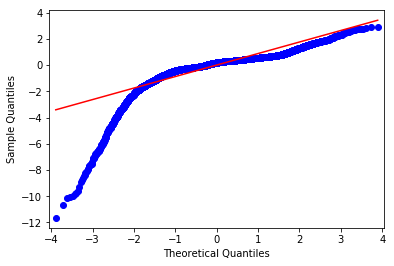

In [47]:
#Getting test predictions
test_preds_m1 = lm1.predict(x_test_m1)

#Calculating residuals
residuals_m1 = test_preds_m1 - y_test

#Making QQ-plot of residuals
sm.qqplot(residuals_m1,line="s");

Now we calculate the mean absolute percent error of the model (MAPE) for comparison to other models.

In [48]:
#Calculate the MAPE
lm1_mape = np.mean(100 * abs((residuals_m1/y_test)))
lm1_mape

24.486227544958503

### Multiple Linear Regression - Log Transformed Target

Based on the residual QQ-plot from the previous model, the assumptions of linear regression were not met. This issue could be happening because **price_ratio** is a bounded quantity. As I mentioned earlier, it is impossible to have a **price_ratio** less than or equal to 0. Additionally, it is extremely rare that a sneaker has a price ratio less than 1 (557 transactions of 99956 observations). But **price_ratio** has no upper bound. Because of this asymmetrical bound, the model predicting raw **price_ratio** values gets wonky around 1. By taking the natural log of **price_ratio** we convert the target into an unbounded logarithmic scale, which improves the symmetry and spread of the target distribution. Looking at the overlaid histogram below, it is clear that the frequencies for individual values goes down quite significantly after log transformatio and that the spread improves. 

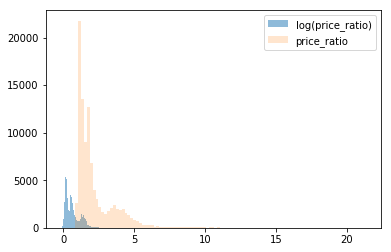

In [49]:
#Plotting the overlaid histogram of the log-transformed target and regular target
plt.hist(np.log(stockx_data["price_ratio"]),bins=100, alpha = 0.5);
plt.hist(stockx_data["price_ratio"], bins = 100, alpha = 0.2);
plt.legend(["log(price_ratio)", "price_ratio"]);

This time when making our copies of the data, we must log transform the training labels (y values). We do not touch the testing data.

In [50]:
#Creating copies of the train/test datasets without brand2 in it AND changing the y test/train to be log transformed. 
x_train_m2 = x_train.copy()
x_train_m2 = x_train_m2.drop(["brand2","other_state"], axis=1)
x_test_m2 = x_test.copy()
x_test_m2 = x_test_m2.drop(["brand2", "other_state"], axis=1)

y_train_m2 = y_train.copy()
y_train_m2 = np.log(y_train_m2)
y_test_m2 = y_test.copy()

Now we create and fit our linear model object. This first model is predicting log transformed **price_ratio** values from both the Yeezy and Off-White data in the same model.  

In [51]:
#Creating the linear model object: lm2
lm2 = linear_model.LinearRegression()

#Fitting the linear model: m2
m2 = lm2.fit(x_train_m2, y_train_m2)

Now we get the parameter estimates, p-values, R-squared, and adjusted R-squared for the log transformed model.

In [52]:
#Printing summary
print("\n=========== SUMMARY ===========")
xlabels = x_train_m2.columns
stats_reg.summary(lm2, x_train_m2, y_train_m2, xlabels)


=========== SUMMARY ===========
Residuals:
    Min      1Q  Median      3Q     Max
-1.8402 -0.1542  0.0599  0.2146  0.7836


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  1.061363    0.007462  142.2447  0.000000
Shoe Size   0.009461    0.000175   54.1387  0.000000
date_diff   0.000015    0.000003    4.4379  0.000009
jordan      0.447876    0.007262   61.6726  0.000000
V2         -0.743512    0.005100 -145.7781  0.000000
blackcol    0.287930    0.003789   75.9935  0.000000
airmax90    0.020843    0.009743    2.1394  0.032410
airmax97    0.080232    0.010900    7.3610  0.000000
zoom       -0.720901    0.007785  -92.6054  0.000000
presto      0.225902    0.007734   29.2093  0.000000
airforce   -0.229710    0.009107  -25.2235  0.000000
blazer      0.346489    0.008139   42.5707  0.000000
vapormax   -0.343320    0.008238  -41.6756  0.000000
california  0.036606    0.002650   13.8112  0.000000
new_york    0.013510    0.002818    4.7950  0.000002
oregon      

Now we predict using the testing predictor data and calculate the residuals. Based on the following QQ-plot for these residuals, this model still breaks the assumption of normally distributed residuals. 

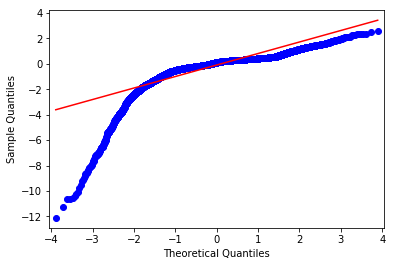

In [53]:
#Getting test predictions
test_preds_m2 = lm2.predict(x_test_m2)

#Calculating residuals
residuals_m2 = np.exp(test_preds_m2) - y_test_m2

#Making QQ-plot of the residuals
sm.qqplot(residuals_m2,line="s");

Now we get the MAPE of the log transformed model. This is a slight improvement (lower MAPE) compared to the previous model. 

In [54]:
#Calculate the MAPE: On average, the log transformed linear model is 22.03% off in predicting price
#ratio. 
lmlog_mape = np.mean(100 * abs(residuals_m2/y_test_m2))
lmlog_mape

22.070558390907753

Based on the results and looking back on the distributions of **price_ratio** for Yeezys and Off-Whites, it makes sense to pursue separate linear regression models for each brand.

### Multiple Linear Regression: Yeezys

Creating the dataset this time around is not quite as simple as dropping unwanted columns. First we drop **other_state** for collinearity concerns. Then we subset the training and testing data for rows in which **brand2** = 1 (Yeezy). After that, we drop **jordan**, **airmax90**, **airmax97**, **zoom**, **presto**, **airforce**, **blazer**, and **vapormax** because those columns exclusively apply to Off-Whites. After that, we drop **brand2**.

In [17]:
#Creating a 3rd copy of the x_train and x_test
x_train_m3 = x_train.copy()
x_train_m3 = x_train_m3.drop(["other_state"], axis=1)
x_test_m3 = x_test.copy()
x_test_m3 = x_test_m3.drop(["other_state"], axis=1)

#Subset only rows with brand2 == 1 (Yeezy). Note that y_train_yeezy is log transformed
x_train_yeezy = x_train_m3.loc[x_train_m3["brand2"] == 1,]
x_test_yeezy = x_test_m3.loc[x_test_m3["brand2"] == 1,]
y_train_yeezy = np.log(y_train.loc[x_train_m3["brand2"] == 1,])
y_test_yeezy = y_test.loc[x_test_m3["brand2"] == 1,]

#Drop: jordan, airmax90, airmax97, zoom, presto, airforce, blazer, vapormax, brand2. 
x_train_yeezy = x_train_yeezy.drop(["jordan", "airmax90", "airmax97", "zoom", \
                                    "presto", "airforce","blazer", "vapormax","brand2"],axis = 1)
x_test_yeezy = x_test_yeezy.drop(["jordan", "airmax90", "airmax97", "zoom",\
                   "presto", "airforce","blazer", "vapormax","brand2"], axis = 1)

Now we create and fit our linear model object. This third model is predicting log transformed **price_ratio** values from only the Yeezy shoes in the data.  

In [56]:
#Creating a linear model object: lm_yeezy
lm_yeezy = linear_model.LinearRegression()

#Training the Yeezy model using the Yeezy train/target
m_yeezy = lm_yeezy.fit(x_train_yeezy, y_train_yeezy)

Now we get the parameter estimates, p-values, R-squared, and adjusted R-squared for the log transformed Yeezy model.

In [57]:
#Printing summary
print("\n=========== SUMMARY ===========")
xlabels = x_train_yeezy.columns
stats_reg.summary(lm_yeezy, x_train_yeezy, y_train_yeezy, xlabels)


=========== SUMMARY ===========
Residuals:
    Min      1Q  Median      3Q     Max
-1.7734 -0.1544  0.0263  0.2271  0.8295


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  1.295154    0.012556  103.1533  0.000000
Shoe Size   0.007168    0.000211   33.9452  0.000000
date_diff  -0.000156    0.000003  -47.6076  0.000000
V2         -0.931920    0.011314  -82.3673  0.000000
blackcol    0.824199    0.006238  132.1305  0.000000
california  0.023755    0.002982    7.9652  0.000000
new_york    0.008527    0.003084    2.7646  0.005701
oregon      0.045073    0.004337   10.3924  0.000000
florida     0.007669    0.004713    1.6273  0.103676
texas      -0.010246    0.004688   -2.1857  0.028843
---
R-squared:  0.30724,    Adjusted R-squared:  0.30713
F-statistic: 2844.34 on 9 features


Now we predict and view the QQ-plot of the residuals. This model also fails to meet the normality of residuals requirement for linear regression. 

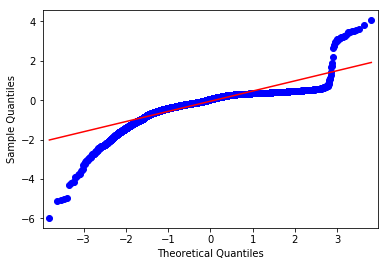

In [58]:
#Getting the test predictions
test_preds_yeezy = lm_yeezy.predict(x_test_yeezy)

#Calculating the residuals. The test predictions have to be exponentiated when compared to the test set.
residuals_yeezy = np.exp(test_preds_yeezy) - y_test_yeezy

#Making the QQ-plot of the residuals
sm.qqplot(residuals_yeezy,line="s");

Here we calculate the MAPE of the Yeezy linear model. Separating by brand seems to have slightly reduced the MAPE in the case of the Yeezys. 

In [59]:
#Calculate the MAPE
lmyeezy_mape = np.mean(100 * abs(residuals_yeezy/y_test_yeezy))
lmyeezy_mape

20.90089303796256

### Multiple Linear Regression: Off-Whites

Similar to how the Yeezy data and labels were created, we subset the data to only rows with **brand2** = 0 (Off-White) and then get rid of **V2** (a strictly Yeezy term) and **brand2**, since it is no longer needed. 

In [43]:
#Creating yeezy and off-white training and testing sets for brand separated models
x_train_offwhite = x_train_m3.loc[x_train_m3["brand2"] == 0,]
x_test_offwhite = x_test_m3.loc[x_test_m3["brand2"] == 0,]

#Taking the natural log of the training target 
y_train_offwhite = np.log(y_train.loc[x_train_m3["brand2"] == 0,])
y_test_offwhite = y_test.loc[x_test_m3["brand2"] == 0,]

#Drop: V2, brand2.
x_train_offwhite = x_train_offwhite.drop(["V2","brand2"],axis=1)
x_test_offwhite = x_test_offwhite.drop(["V2","brand2"],axis=1)

Now we create and fit our linear model object. This fourth linear model is predicting log transformed **price_ratio** values from only the Off-White shoes in the data.  

In [61]:
#Creating linear regression object for the Off-Whites
lm_offwhite = linear_model.LinearRegression()

#Training the Off-White model using the Off-White train/target
m_offwhite = lm_offwhite.fit(x_train_offwhite, y_train_offwhite)

In [62]:
#Printing summary
print("\n=========== SUMMARY ===========")
xlabels = x_train_offwhite.columns
stats_reg.summary(lm_offwhite, x_train_offwhite, y_train_offwhite, xlabels)


=========== SUMMARY ===========
Residuals:
    Min    1Q  Median      3Q     Max
-1.7974 -0.11  0.0221  0.1479  0.6967


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  0.601594    0.010727   56.0818  0.000000
Shoe Size   0.011133    0.000264   42.1456  0.000000
date_diff   0.001363    0.000015   87.9467  0.000000
jordan      0.820576    0.007233  113.4456  0.000000
blackcol    0.032885    0.003877    8.4809  0.000000
airmax90    0.493953    0.009178   53.8188  0.000000
airmax97    0.483276    0.010069   47.9986  0.000000
zoom       -0.237747    0.007651  -31.0759  0.000000
presto      0.698351    0.007602   91.8649  0.000000
airforce    0.270938    0.008682   31.2071  0.000000
blazer      0.726895    0.007901   92.0031  0.000000
vapormax    0.082580    0.008019   10.2984  0.000000
california  0.030268    0.003931    7.7006  0.000000
new_york    0.011215    0.004456    2.5168  0.011850
oregon      0.006309    0.006058    1.0415  0.297647
florida     0.00

Now we predict and view the QQ-plot of the residuals. Like all previous linear models, this one fails to meet the normality of residuals requirement for linear regression. 

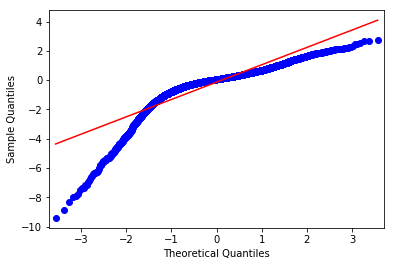

In [63]:
#Getting test predictions
test_preds_offwhite = lm_offwhite.predict(x_test_offwhite)

#Calculating residuals
residuals_offwhite = np.exp(test_preds_offwhite) - y_test_offwhite

#Plotting QQ-plot
sm.qqplot(residuals_offwhite,line="s");

Now we calculate the MAPE of the Off-White model. This one is the best performing model, and this is most likely due to the greater number of effective predictors in the Off-White dataset as compared to the Yeezy dataset. 

In [64]:
#Calculate the MAPE
lmoffwhite_mape = np.mean(100 * abs(residuals_offwhite/y_test_offwhite))
lmoffwhite_mape

16.872500274511413

After these four failed modeling attempts with linear regression, the best course of action is to pursue a model that does not have strict assumptions like those of linear regression. Random forest model it is!

### Random Forest
The first random forest model runs on both Yeezy and Off-White data to predict **price_ratio**.

I settled on two hyperparameters to tune: number of regression trees and maximum number of features considered for each split. My process with optimizing the number of regression trees was quite simple, I just ran 4 different random forests with 10, 100, 500, and 1000 trees in them and looked at the MAPEs to determine where the point of diminishing returns was, and apply that number of trees for all subsequent models. As for the maximum number of features in a split, I created a function that can adapt to any dataset and outputs MAPEs for each possible value of max_features in the sklearn function RandomForestRegressor. I would then look for the lowest MAPE and report that as the final random forest regression model. 

Here we make some fresh copies of the originally split data. The training set has to be further broken into training and validation in anticipation of hyperparameter tuning. Ultimately the split here is 60% training, 20% validation, and 20% test data.

In [19]:
#Creating the copies of the training, testing, and validation data for the general random forest model
x_train_m4 = x_train.copy()
x_test_m4 = x_test.copy()

y_train_m4 = y_train.copy()
y_test_m4 = y_test.copy()


x_train_m4_small, x_valid, y_train_m4_small, y_valid = train_test_split(x_train_m4,y_train_m4,test_size = 0.25)

I settled on two hyperparameters to tune: number of regression trees and maximum number of features considered at each split. The code below shows how I selected the number of trees. Knowing that more trees equates to more run time, I picked the tree value that seemed to mark the beginning of the point of diminished returns, which in this case was 100 trees. All random forest models use 100 trees. 

In [20]:
#Testing 10, 100, 500, 1000 trees for their resulting MAPE values. 
trees_to_test = [10, 100, 500, 1000]
tree_mapes = {}
for i in trees_to_test:
    rf_treevalid = RandomForestRegressor(random_state=np.random.seed(42), n_estimators=i)
    rf_treevalid.fit(x_train_m4_small, y_train_m4_small)
    rf_treevalid_preds = rf_treevalid.predict(x_valid)
    rf_treevalid_errors = rf_treevalid_preds - y_valid
    mape = mean(100 * abs((rf_treevalid_errors/rf_treevalid_preds)))
    tree_mapes.update({i:mape})

tree_mapes

{10: 17.47331926011413,
 100: 17.187102968106814,
 500: 17.15515866882791,
 1000: 17.157915831044022}

The next hyperparameter I selected for tuning is the maximum features considered at every split. To do this effectively, I created a function that inputs a training data, training labels, testing data, testing labels, and number of trees. For every value from 1 to the total number of features in the data, this function will fit a random forest on the testing with 100 trees, and return the MAPE. I then pick the lowest MAPE and that corresponding number of features and that is the final random forest model. 

In [21]:
#Creating a new function max_features_tuning to find the best value for max_features (meaning number 
#of features considered at every node) for each random forest. Trees will default to 100 because 
#that's what I determined to be the best tradeoff of accuracy vs runtime, but it can be altered.
def max_features_tuning (xtrainset, ytrainset, xvalidset, yvalidset, trees = 100):
    MAPE_values = {}
    for i in range(0, xtrainset.shape[1]):
        rf = RandomForestRegressor(random_state=np.random.seed(42), n_estimators=trees,\
                                   max_features=i+1)
        rf.fit(xtrainset, ytrainset)
        rf_preds = rf.predict(xvalidset)
        rf_errors = rf_preds - yvalidset
        mape = mean(100 * abs((rf_errors/rf_preds)))
        MAPE_values.update({i+1:mape})
    return MAPE_values

The output below shows each possible value of the max features parameter and the corresponding MAPE. The best value for max features for this model is 12.

In [22]:
#Looking for the best max_features value using training and validation set
max_features_tuning(xtrainset=x_train_m4_small, ytrainset=y_train_m4_small,\
                    xvalidset=x_valid, yvalidset = y_valid, trees = 100) 

{1: 17.408480455320845,
 2: 17.38573418217717,
 3: 17.341318114640472,
 4: 17.305922700264787,
 5: 17.28213083880628,
 6: 17.22375457991098,
 7: 17.180992130584144,
 8: 17.153795662725074,
 9: 17.115757668900706,
 10: 17.107120277985327,
 11: 17.105195500687014,
 12: 17.081304489539725,
 13: 17.098639399282252,
 14: 17.092345829281022,
 15: 17.11769662828325,
 16: 17.140016020313343,
 17: 17.141027852619388,
 18: 17.16826702432452,
 19: 17.187102968106814}

Now that trees and max features at any split have been optimized, I rerun the random forest to get the feature importances for the model. 

In [23]:
#Rerun the general Random forest with the optimal parameters  
rf = RandomForestRegressor(random_state=np.random.seed(42), max_features=12, n_estimators=100)
rf.fit(x_train_m4, y_train_m4)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=12, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

The output below shows the feature importances for this random forest model. The most important variable for this random forest is **V2**, or whether or not a sneaker is a Yeezy 350 Boost V2. 

In [24]:
#Print list of feature importances
features = x_train_m4.columns
importances = list(rf.feature_importances_)
for i in range(0,len(importances)):
    print(features[i], "----", "importance: ", importances[i])

Shoe Size ---- importance:  0.050395232310618834
date_diff ---- importance:  0.20761292492964023
jordan ---- importance:  0.08030481037927256
V2 ---- importance:  0.3278791073374367
blackcol ---- importance:  0.04533011158398275
airmax90 ---- importance:  0.004251612603459441
airmax97 ---- importance:  0.0029276956227926847
zoom ---- importance:  0.08055805274609852
presto ---- importance:  0.021995767571636522
airforce ---- importance:  0.013504258636962632
blazer ---- importance:  0.014667269976344191
vapormax ---- importance:  0.03051001088064317
california ---- importance:  0.003283308897902821
new_york ---- importance:  0.0032179768300828284
oregon ---- importance:  0.0024363060858362184
florida ---- importance:  0.002157033520069525
texas ---- importance:  0.0019016330912944455
other_state ---- importance:  0.0037287576519955466
brand2 ---- importance:  0.10333812934393055


Below we run the tuned random forest on the test dataset to get a final performance metric on unseen data. 

In [25]:
test_preds = rf.predict(x_test_m4)
test_errors = test_preds - y_test_m4
test_mape = mean(100 * abs((test_errors/test_preds)))
test_mape

16.844611402991486

Just like with linear regression, we now create brand separated random forest models. 

### Random Forest: Yeezys

The Yeezy train/test data and labels were already created earlier in the notebook when we made the Yeezy linear regression. We have to exponentiate the y-training labels because there is no longer a reason to log-transform **price_ratio**. 

In [26]:
#Exponentiating the y_train_yeezy to undo the log-transform for the Yeezy linear model
y_train_yeezy = np.exp(y_train_yeezy)

In [27]:
#Separating the training set into training, validation, and test datasets
x_train_yeezy_small, x_valid_yeezy, y_train_yeezy_small, y_valid_yeezy = train_test_split(x_train_yeezy,y_train_yeezy,\
                                                                                          test_size = 0.25)

The output below shows each possible value of the max features parameter and the corresponding MAPE. The best value of max features for the Yeezy random forest is 6.

In [38]:
#Looking for the best max_features value 
max_features_tuning(xtrainset=x_train_yeezy_small, ytrainset=y_train_yeezy_small,\
                    xvalidset=x_valid_yeezy, yvalidset = y_valid_yeezy, trees = 100) 

{1: 19.09669755274352,
 2: 19.09014615469371,
 3: 19.031056538661023,
 4: 18.952102839481444,
 5: 18.887909701582235,
 6: 18.875162121887534,
 7: 18.908774418789026,
 8: 18.9599771989283,
 9: 18.995282561423352}

Now we rerun the Yeezy random forest with the optimized parameters.

In [39]:
#Rerun the Yeezy Random forest with the optimal parameters for 
rf_yeezy = RandomForestRegressor(random_state=np.random.seed(42), max_features=6, n_estimators=100)
rf_yeezy.fit(x_train_yeezy, y_train_yeezy)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

The output below contains the feature importances for the Yeezy model. The most important variable is **blackcol**, or whether or not a Yeezy has black in the colorway. 

In [40]:
#Print list of feature importance
features = x_train_yeezy.columns
importances = list(rf_yeezy.feature_importances_)
for i in range(0,len(importances)):
    print(features[i], "----", "importance: ", importances[i])

Shoe Size ---- importance:  0.10645130974951274
date_diff ---- importance:  0.3387571568104829
V2 ---- importance:  0.15883959192943903
blackcol ---- importance:  0.3516795840238471
california ---- importance:  0.010299113901521842
new_york ---- importance:  0.01182657605608846
oregon ---- importance:  0.006210718998793239
florida ---- importance:  0.008492757703351663
texas ---- importance:  0.007443190826963137


Below we run the tuned Yeezy random forest on the test dataset to get a final performance metric on unseen data. 

In [41]:
test_preds = rf_yeezy.predict(x_test_yeezy)
test_errors = test_preds - y_test_yeezy
test_mape = mean(100 * abs((test_errors/test_preds)))
test_mape

18.934505370655422

### Random Forest: Off-Whites

We repeat the same data transformation for the Off-White training labels as we did with the Yeezy training labels. 

In [44]:
#Exponentiating the y_train_offwhite to undo the log-transform for the Off-White linear model
y_train_offwhite = np.exp(y_train_offwhite)

Here we separate the Off-White training data into training and validation for hyperparameter tuning.

In [45]:
#Separating the training set into training, validation, and test datasets
x_train_offwhite_small, x_valid_offwhite, y_train_offwhite_small, y_valid_offwhite = train_test_split(x_train_offwhite,\
                                                                                                      y_train_offwhite,\
                                                                                                      test_size = 0.25)

The output below shows each possible value of the max features parameter and the corresponding MAPE. The best value for the max features in the Off-White random forest is 11. 

In [46]:
#Looking for the best max_features value 
max_features_tuning(xtrainset=x_train_offwhite_small, ytrainset=y_train_offwhite_small,\
                    xvalidset=x_valid_offwhite, yvalidset = y_valid_offwhite, trees = 100) 

{1: 12.377834333715402,
 2: 12.303493254943696,
 3: 12.212604891796738,
 4: 12.070428503665593,
 5: 12.013451883209292,
 6: 11.896210483335043,
 7: 11.87443931076127,
 8: 11.813600012117684,
 9: 11.81376966616931,
 10: 11.804110196352854,
 11: 11.786658819340762,
 12: 11.848103682701485,
 13: 11.829993979147238,
 14: 11.817021599928449,
 15: 11.842236798493627,
 16: 11.8415528191091}

Now we rerun the optimized Off-White random forest to get the feature importance.

In [47]:
#Rerun the optimized random forest
rf_offwhite = RandomForestRegressor(random_state=42,max_features=11, n_estimators=100)
rf_offwhite.fit(x_train_offwhite, y_train_offwhite)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=11, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

The output below shows the feature importance for the Off-White random forest. The most important variable is **date_diff**. 

In [48]:
#Print the feature importance
features = x_train_offwhite.columns
importances = list(rf_offwhite.feature_importances_)
#importances
for i in range(0,len(importances)):
    print(features[i], "----", "importance: ", importances[i])

Shoe Size ---- importance:  0.0855877255040768
date_diff ---- importance:  0.3764687885742764
jordan ---- importance:  0.12389757553156164
blackcol ---- importance:  0.008417192920324269
airmax90 ---- importance:  0.010520696609461446
airmax97 ---- importance:  0.007184038541338946
zoom ---- importance:  0.17856777823591283
presto ---- importance:  0.04041229472619601
airforce ---- importance:  0.033698056999216415
blazer ---- importance:  0.03587133304719833
vapormax ---- importance:  0.0676370102178475
california ---- importance:  0.009083758659087712
new_york ---- importance:  0.008413527630298727
oregon ---- importance:  0.005386898694457153
florida ---- importance:  0.00473181826786348
texas ---- importance:  0.004121505840882445


Below we run the tuned Off-White random forest on the test dataset to get a final performance metric on unseen data. 

In [49]:
test_preds = rf_offwhite.predict(x_test_offwhite)
test_errors = test_preds - y_test_offwhite
test_mape = mean(100 * abs((test_errors/test_preds)))
test_mape

11.644956960532998

Conclusions
----------------
In this analysis, we used sneaker transaction data from StockX to understand what makes certain sneakers hype. We found that it is possible to predict the hype of a sneaker, represented by the ratio of sale price to retail price. We were able to determine the most important factors in predicting the hype of a sneaker, such as number of days after release or whether a shoe was a Yeezy Boost 350 V2 or not. StockX can use these results to make decisions on which sneakers to promote to buyers based on how they want to balance maximal revenue with buyer interests.